In [171]:
import os
import numpy as np
import nibabel as nib
import nibabel.orientations as nio
import matplotlib.pyplot as plt

# custom
from data_utilities import *

directory = 'D:\\racunalni_vid\dataset-verse19test\dataset-verse19test\derivatives\sub-verse119'

# Step 4: Load files for a single data sample
img_nib = nib.load(os.path.join(directory, 'sub-verse119_ct.nii.gz'))
msk_nib = nib.load(os.path.join(directory, 'sub-verse119_seg-vert_msk.nii.gz'))
ctd_list = load_centroids(os.path.join(directory, 'sub-verse119_seg-subreg_ctd.json'))


In [172]:
#check img zooms 
zooms = img_nib.header.get_zooms()
print('img zooms = {}'.format(zooms))

#check img orientation
axs_code = nio.ornt2axcodes(nio.io_orientation(img_nib.affine))
print('img orientation code: {}'.format(axs_code))

#check centroids
print('Centroid List: {}'.format(ctd_list))

img zooms = (1.0, 1.0, 1.9992723)
img orientation code: ('P', 'I', 'R')
Centroid List: [('P', 'I', 'R'), [8, 37.2, 26.4, 19.7], [9, 48.8, 41.7, 18.2], [10, 57.6, 57.5, 17.4], [11, 64.5, 74.3, 17.0], [12, 68.6, 93.1, 18.4], [13, 71.4, 112.8, 19.7], [14, 71.7, 133.3, 20.2], [15, 71.4, 151.7, 20.8], [16, 68.0, 172.1, 21.2], [17, 66.5, 194.5, 21.2], [18, 65.9, 219.3, 20.8], [19, 63.7, 242.3, 19.3], [20, 57.6, 268.7, 17.7]]


In [173]:
# Resample and Reorient data
img_iso = resample_nib(img_nib, voxel_spacing=(1, 1, 1), order=3)
msk_iso = resample_nib(msk_nib, voxel_spacing=(1, 1, 1), order=0) # or resample based on img: resample_mask_to(msk_nib, img_iso)
ctd_iso = rescale_centroids(ctd_list, img_nib, (1,1,1))

img_iso = reorient_to(img_iso, axcodes_to=('I', 'P', 'L'))
msk_iso = reorient_to(msk_iso, axcodes_to=('I', 'P', 'L'))
ctd_iso = reorient_centroids_to(ctd_iso, img_iso)

#check img zooms 
zooms = img_iso.header.get_zooms()
print('img zooms = {}'.format(zooms))

#check img orientation
axs_code = nio.ornt2axcodes(nio.io_orientation(img_iso.affine))
print('img orientation code: {}'.format(axs_code))

#check centroids
print('new centroids: {}'.format(ctd_iso))

[*] Image resampled to voxel size: (1, 1, 1)
[*] Image resampled to voxel size: (1, 1, 1)
[*] Rescaled centroid coordinates to spacing (x, y, z) = (1, 1, 1) mm
img zooms = (1.0, 1.0, 1.0)
img orientation code: ('I', 'P', 'L')
new centroids: [('I', 'P', 'L'), [8, 26.4, 37.2, 46.6], [9, 41.7, 48.8, 49.6], [10, 57.5, 57.6, 51.2], [11, 74.3, 64.5, 52.0], [12, 93.1, 68.6, 49.2], [13, 112.8, 71.4, 46.6], [14, 133.3, 71.7, 45.6], [15, 151.7, 71.4, 44.4], [16, 172.1, 68.0, 43.6], [17, 194.5, 66.5, 43.6], [18, 219.3, 65.9, 44.4], [19, 242.3, 63.7, 47.4], [20, 268.7, 57.6, 50.6]]


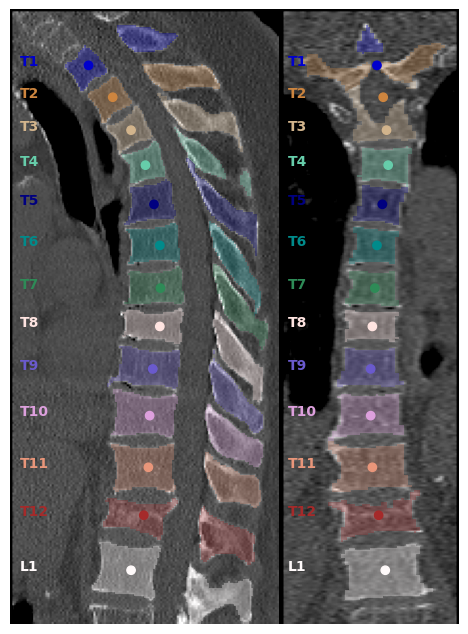

In [174]:
# get vocel data
im_np  = img_iso.get_fdata()
msk_np = msk_iso.get_fdata()

# get the mid-slice of the scan and mask in sagittal plane
im_np_sag = im_np[:,:,int(im_np.shape[2]/2)]
im_np_cor = im_np[:,int(im_np.shape[1]/2),:]

msk_np_sag = msk_np[:,:,int(msk_np.shape[2]/2)]
msk_np_sag[msk_np_sag==0] = np.nan

msk_np_cor = msk_np[:,int(msk_np.shape[1]/2),:]
msk_np_cor[msk_np_cor==0] = np.nan


# plot 
fig, axs = create_figure(96,im_np_sag, im_np_cor)

axs[0].imshow(im_np_sag, cmap=plt.cm.gray, norm=wdw_sbone)
axs[0].imshow(msk_np_sag, cmap=cm_itk, alpha=0.3, vmin=1, vmax=64)
plot_sag_centroids(axs[0], ctd_iso, zooms)

axs[1].imshow(im_np_cor, cmap=plt.cm.gray, norm=wdw_sbone)
axs[1].imshow(msk_np_cor, cmap=cm_itk, alpha=0.3, vmin=1, vmax=64)
plot_cor_centroids(axs[1], ctd_iso, zooms)

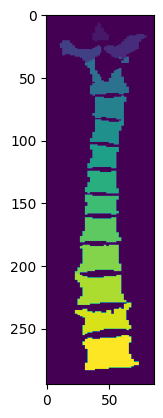

In [175]:
plt.imshow(msk_np_cor)
import skimage

labeled = skimage.measure.label(msk_np_cor)
plt.imshow(labeled)

63.62018689192456
154.49768458048766
12.090112038697043
135.0
148.31235159520804
22.345877689275596
177.92811009216953
167.64938200829567
173.86161725144314
2.9380064639806562
1.7359398585265922
0.18142792191801504
173.66876081220408
2.2364905212051553
174.49120147046526
179.18283261992966


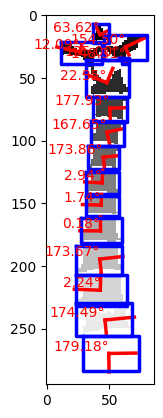

In [176]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure

# Assuming 'labeled' is your labeled array obtained from skimage.measure.label

# Measure region properties
regions = skimage.measure.regionprops(labeled)

# Plot the original image
plt.imshow(msk_np_cor, cmap='gray')

# Get the areas of all regions
areas = [props.area for props in regions]

# Find the index of the largest region
largest_region_index = np.argmax(areas)

matching_bounding_boxes = []
rotation_angles = []

# Loop through each region
for idx, props in enumerate(regions):
    # Exclude the largest region
    if idx != largest_region_index:
        # Get centroid and orientation
        y0, x0 = props.centroid
        orientation = props.orientation
        
        # Calculate endpoints for major and minor axes
        x1 = x0 + np.cos(orientation) * 0.5 * props.minor_axis_length
        y1 = y0 - np.sin(orientation) * 0.5 * props.minor_axis_length
        x2 = x0 - np.sin(orientation) * 0.5 * props.major_axis_length
        y2 = y0 - np.cos(orientation) * 0.5 * props.major_axis_length
        
        # Draw major and minor axes
        plt.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
        plt.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
        
        # Draw bounding box
        minr, minc, maxr, maxc = props.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        plt.plot(bx, by, '-b', linewidth=2.5)

        angle_rad = np.arctan2(y2 - y0, x2 - x0)
        angle_deg = np.degrees(angle_rad)
            
            # Ensure angle is between 0 and 180 degrees
        if angle_deg < 0:
            angle_deg += 180
            
            # Add text annotation to the plot
        plt.text(x0, y0, f"{angle_deg:.2f}°", color='red', ha='right', va='bottom')
        print(angle_deg)
        rotation_angles.append(angle_deg)


plt.show()


Cobb Angle (degrees): 33.60033262752029


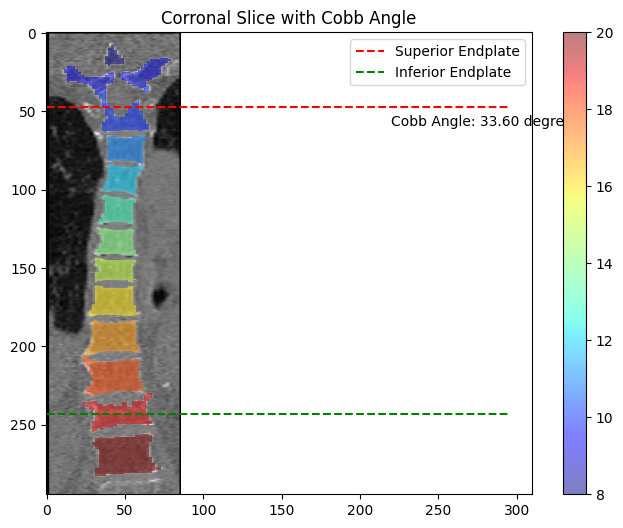

In [177]:
def calculate_cobb_angle(mask_data):
    # Find the indices of the superior and inferior endplates
    endplate_indices = np.where(~np.isnan(mask_data))

    # Assume we found the superior and inferior indices correctly
    #ignores first and last few vertebraes that arent masked correctly
    sup_endplate_idx = np.min(endplate_indices) +40
    inf_endplate_idx = np.max(endplate_indices) -40

    # Calculate the Cobb angle using the indices
    cobb_angle = np.arctan((inf_endplate_idx - sup_endplate_idx) / mask_data.shape[0]) * 180 / np.pi

    return cobb_angle, sup_endplate_idx, inf_endplate_idx

# Calculate Cobb angle for the mid-slice in sagittal plane
cobb_angle, sup_idx, inf_idx = calculate_cobb_angle(msk_np_cor)
print("Cobb Angle (degrees):", cobb_angle)

# Plot the mid-slice image
plt.figure(figsize=(8, 6))
plt.imshow(im_np_cor, cmap='gray')
plt.title('Corronal Slice with Cobb Angle')

# Plot the mask overlay
plt.imshow(msk_np_cor, cmap='jet', alpha=0.5)

# Plot lines for the Cobb angle
plt.plot([0, msk_np_cor.shape[0]], [sup_idx, sup_idx], 'r--', label='Superior Endplate')
plt.plot([0, msk_np_cor.shape[0]], [inf_idx, inf_idx], 'g--', label='Inferior Endplate')

# Add Cobb angle text
plt.text(220, msk_np_cor.shape[0] // 5, f'Cobb Angle: {cobb_angle:.2f} degrees', color='black')

plt.colorbar()
plt.legend()
plt.show()